In [ ]:
import numpy as np
from dataclasses import dataclass
from scipy.optimize import minimize
from scipy.optimize import brentq

from matplotlib import pyplot as plt

# Function for computing the Jfactor penalty

In [2]:
def jfactor_penalty(lam, sigma, *, dist="lognormal", logbase="10"):
    """
    J-factor penalty for UL rescaling.

    Parameters
    ----------
    lam : float or array-like
        Lambda parameter from the UL / likelihood curvature.
    sigma : float or array-like
        J-factor uncertainty.
        - Normal: relative uncertainty sigma_J/J
        - Lognormal: sigma in ln(J) or log10(J)
    dist : {"lognormal", "normal"}
        Uncertainty model.

    Returns
    -------
    penalty : float or np.ndarray
        Multiplicative penalty factor.
    """

    lam = np.asarray(lam, dtype=float)
    sigma = np.asarray(sigma, dtype=float)

    if np.any(sigma < 0):
        raise ValueError("All sigma values must be > 0")

        
    dist = dist.lower()

    if dist == "normal":
        arg = 1.0 - lam * sigma**2
        if np.any(arg <= 0):
            raise ValueError(
                "Gaussian penalty requires 1 - lambda*sigma^2 > 0 everywhere"
            )
        penalty = 1.0 / np.sqrt(arg)

    elif dist == "lognormal":
        if logbase == "10":

            sigma = sigma * np.log(10.0)
        elif logbase != "e":
            raise ValueError("logbase must be 'e' or '10'")
        
        eps = np.sqrt(0.25 + lam * sigma**2) - 0.5
        penalty = np.sqrt(eps) / (sigma *np.sqrt(lam) ) * np.exp(eps)

    else:
        raise ValueError("dist must be 'normal' or 'lognormal'")

    return penalty

In [3]:
# Example usage of penalty function
jfactor_penalty(lam=2.71, sigma=1, dist="lognormal", logbase='10')

13.347789003725001

Log10 Sigma   Penalty 
  0.1          1.1
  0.2          1.3
  0.3          1.6
  0.4          2.1
  0.5          2.7
  0.6          3.7
  0.7          5.0
  0.8          6.9
  0.9          9.6
  1.0         13.3
  1.1         18.6
  1.2         26.1
  1.3         36.8
  1.4         51.9
  1.5         73.3
  1.6        103.9
  1.7        147.4
  1.8        209.5
  1.9        298.1
  2.0        424.9


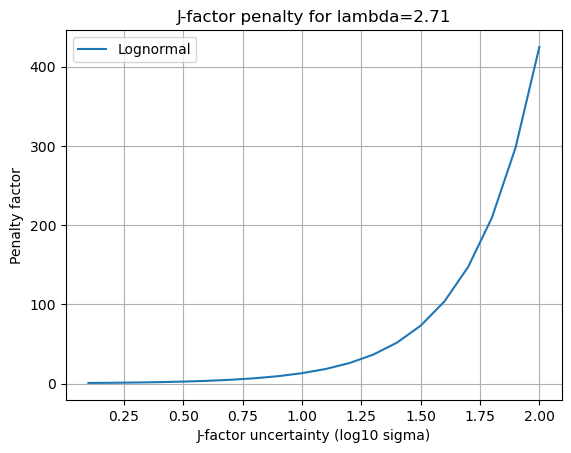

In [4]:
sigma = np.linspace(0.1, 2.0, 20)
lam = 2.71
pen_log = jfactor_penalty(lam, sigma, dist="lognormal", logbase='10')

print("Log10 Sigma   Penalty ")

for s, p in zip(sigma, pen_log):
    print(f"{s:5.1f}   {p:10.1f}")

plt.plot(sigma, pen_log, label="Lognormal")
plt.xlabel("J-factor uncertainty (log10 sigma)")
plt.ylabel("Penalty factor")
plt.title(f"J-factor penalty for lambda={lam}")
plt.grid()
plt.legend()
plt.show()

# Class for the Toy MC simulations

In [24]:

@dataclass
class ToyConfig:
    alpha: float = 0.1
    b_true: float = 200.0
    J0: float = 1.0
    k: float = 1.0
    cl_qmu: float = 2.71  # 95% one-sided (Wilks, 1 dof)
    # If your sigma is in dex (log10), set sigma_is_dex=True
    sigma_is_dex: bool = True


def _sigma_lnJ(sigma, sigma_is_dex=True):
    # Convert sigma in dex (log10) to natural-log sigma if needed
    return sigma * np.log(10.0) if sigma_is_dex else sigma


def nll_onoff(mu, b, J, n_on, n_off, alpha, k, J0, sigma=None, distribution="lognormal"):
    """
    Negative log-likelihood for ON/OFF with optional lognormal prior on J.
    Parameters constrained externally: mu>=0, b>=0, J>0.
    """
    lam_on = alpha * b + k * J * mu
    lam_off = b

    # Poisson NLL up to additive constants:
    # -ln P(n|lam) = lam - n ln(lam) + const
    # Guard against lam_on=0 with n_on>0 etc.
    if lam_on <= 0 or lam_off <= 0:
        return np.inf

    nll = (lam_on - n_on * np.log(lam_on)) + (lam_off - n_off * np.log(lam_off))

    if distribution == "lognormal":
        # Lognormal prior: ln J ~ N(ln J0, sigma_lnJ)
        if sigma is not None and sigma > 0:
            z = (np.log(J) - np.log(J0)) / sigma
            nll +=   0.5* z * z   # drop const term
    elif distribution == "normal":
        # normal prior: J ~ N(J0, sigma)
        if sigma is not None and sigma > 0:
            z = (J - J0) / sigma
            nll +=   0.5* z * z   # drop const term
    else:
        raise ValueError(f"Unknown prior distribution: {distribution!r}, must be 'lognormal' or 'normal'")


    return nll


def _fit_hat(n_on, n_off, cfg: ToyConfig, sigma=None, mu_fixed=None, J_fixed=None, distribution="lognormal"):
    """
    Profile likelihood fit.
    If mu_fixed is not None, mu is fixed to that value.
    If J_fixed is not None, J is fixed to that value.
    Returns (nll_min, mu_hat, b_hat, J_hat).
    """
    alpha, k, J0 = cfg.alpha, cfg.k, cfg.J0

    # Variables: we optimize in unconstrained space via log for b and J, and log for mu when free
    # but allow mu=0 by optimizing over x_mu then mu=softplus(x_mu).
    def softplus(x):
        return np.log1p(np.exp(x))

    # Initial guesses
    b0 = max(n_off, 1e-3)               # off roughly background
    mu0 = 0.0
    J0_init = J_fixed if J_fixed is not None else J0

    # Pack parameters
    x0 = []
    if mu_fixed is None:
        x0.append(-10.0)  # softplus(-10) ~ 0
    x0.append(np.log(max(b0, 1e-9)))
    if J_fixed is None:
        x0.append(np.log(max(J0_init, 1e-9)))
    x0 = np.array(x0, dtype=float)

    def unpack(x):
        i = 0
        if mu_fixed is None:
            mu = softplus(x[i]); i += 1
        else:
            mu = float(mu_fixed)
        b = np.exp(x[i]); i += 1
        if J_fixed is None:
            J = np.exp(x[i]); i += 1
        else:
            J = float(J_fixed)
        return mu, b, J

    def obj(x):
        mu, b, J = unpack(x)
        return nll_onoff(mu, b, J, n_on, n_off, alpha, k, J0, sigma=sigma, distribution=distribution)

    res = minimize(obj, x0, method="Nelder-Mead",
                   options={"maxiter": 20000, "xatol": 1e-10, "fatol": 1e-10})
    if not res.success:
        # Fall back: still return best found
        pass

    mu_hat, b_hat, J_hat = unpack(res.x)
    nll_min = obj(res.x)
    return nll_min, mu_hat, b_hat, J_hat


def qmu(mu_test, n_on, n_off, cfg: ToyConfig, sigma=None, J_fixed=None, distribution="lognormal"):
    """
    Profile-likelihood test statistic q_mu for a given mu_test.
    """
    # Global MLE (mu free)
    nll_hat, mu_hat, b_hat, J_hat = _fit_hat(
        n_on, n_off, cfg, sigma=sigma, mu_fixed=None, J_fixed=J_fixed, distribution=distribution
    )

    # Constrain mu = mu_test
    nll_mu, *_ = _fit_hat(
        n_on, n_off, cfg, sigma=sigma, mu_fixed=mu_test, J_fixed=J_fixed, distribution=distribution
    )

    # One-sided convention: if mu_hat > mu_test, set q_mu=0
    if mu_hat > mu_test:
        return 0.0

    return max(0.0, 2.0 * (nll_mu - nll_hat))


def find_ul(n_on, n_off, cfg: ToyConfig, sigmaJ=0.0, J_fixed=None, distribution="lognormal", mu_max=1e4):
    """
    Find mu such that q_mu(mu)=cfg.cl_qmu.
    If J_fixed is not None, uses fixed-J analysis.
    If J_fixed is None and sigmaJ>0, profiles J with lognormal prior.
    """

    
    sigma = None
    if distribution == "lognormal":
        if J_fixed is None and sigmaJ and sigmaJ > 0:
            sigma = _sigma_lnJ(sigmaJ, cfg.sigma_is_dex)
    elif distribution == "normal":
        if J_fixed is None and sigmaJ and sigmaJ > 0:
            sigma = sigmaJ
    else:
        raise ValueError("distribution must be 'lognormal' or 'normal'")

    target = cfg.cl_qmu

    # Bracket root
    def f(mu):
        return qmu(mu, n_on, n_off, cfg, sigma=sigma, J_fixed=J_fixed, distribution=distribution) - target

    lo = 0.0
    hi = 1.0
    # Increase hi until f(hi)>0 (q_mu crosses target)
    for _ in range(60):
        if f(hi) > 0:
            break
        hi *= 2.0
        if hi > mu_max:
            return np.nan

    # Root find
    return brentq(f, lo, hi, maxiter=200, xtol=1e-6, rtol=1e-6)


def run_toys(n_toys=200, sigmas=(0.0, 0.2, 0.4, 0.6, 0.8), seed=None, cfg=ToyConfig(),distribution="lognormal"):
    """ 

    Run toy MC to evaluate UL rescaling with J-factor uncertainties.
    Parameters
    ----------
    n_toys : int 
        Number of toy experiments to run.
    sigmas : iterable of float
        J-factor uncertainties to test (in dex if cfg.sigma_is_dex=True).
    seed : int
        Random seed.
    cfg : ToyConfig
        Toy configuration.
    distribution : {"lognormal", "normal"}
        Uncertainty model for J-factor. Default is "lognormal".
    Returns 
    -------
    summary : dict
        Summary statistics for each sigma: (mean ratio, std error, n valid toys).
    results : dict
        Full list of UL ratios for each sigma.  
    """
    rng = np.random.default_rng(seed)

    results = {s: [] for s in sigmas}

    for _ in range(n_toys):
        n_off = rng.poisson(cfg.b_true)
        n_on  = rng.poisson(cfg.alpha * cfg.b_true)

        # Fixed-J UL (J=J0)
        ul_fix = find_ul(n_on, n_off, cfg, sigmaJ=0.0, J_fixed=cfg.J0, distribution=distribution)

        for s in sigmas:
            # Profile-J UL with sigma s (if s=0, this is effectively fixed by the prior width -> but we still treat as fixed here)
            if s == 0.0:
                ul_prof = ul_fix
            else:
                ul_prof = find_ul(n_on, n_off, cfg, sigmaJ=s, J_fixed=None, distribution=distribution)

            if np.isfinite(ul_fix) and ul_fix > 0 and np.isfinite(ul_prof):
                results[s].append(ul_prof / ul_fix)

    # Summaries
    summary = {}
    for s, arr in results.items():
        arr = np.array(arr, dtype=float)
        if arr.size == 0:
            summary[s] = (np.nan, np.nan, 0)
        else:
            summary[s] = (arr.mean(), arr.std(ddof=1) , arr.size)
    return summary, results




# Assuming Gaussian Prior

In [34]:
cfg = ToyConfig(alpha=0.1, b_true=200.0, J0=1.0, k=1.0, sigma_is_dex=False)
sigmas = (0.01, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3)
summary, raw = run_toys(n_toys=50, sigmas=sigmas, seed=None, cfg=cfg, distribution="normal")

print("sigmaJ  <UL_prof/UL_fix>  stat_err  N")

all_frac_means = []
all_frac_errs = []
for s in sigmas:
    m, se, n = summary[s]
    all_frac_means.append(m)
    all_frac_errs.append(se)
    print(f"{s:5.2f}   {m:10.4f}      {se:7.4f}  {n:4d}")

all_frac_means = np.array(all_frac_means)
all_frac_errs = np.array(all_frac_errs)

sigmaJ  <UL_prof/UL_fix>  stat_err  N
 0.01       1.0001       0.0001    50
 0.03       1.0012       0.0005    50
 0.05       1.0034       0.0013    50
 0.07       1.0076       0.0029    50
 0.10       1.0137       0.0053    50
 0.15       1.0317       0.0126    50
 0.20       1.0589       0.0240    50
 0.25       1.0976       0.0414    50
 0.30       1.1521       0.0675    50


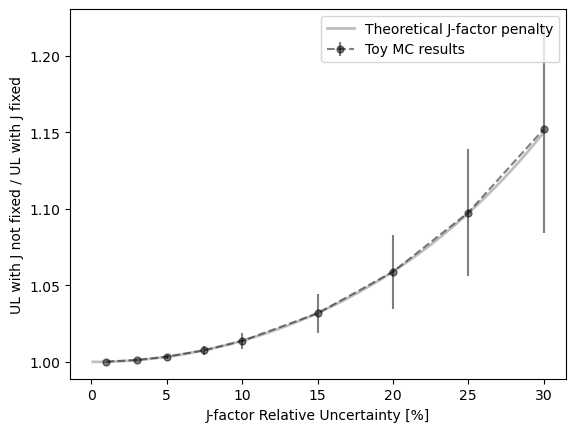

In [35]:

x = np.linspace(0.001,0.3, 100)
y = jfactor_penalty(lam=2.71, sigma=x, dist="normal")
plt.errorbar(np.array(sigmas)*100, all_frac_means, yerr=all_frac_errs, marker='o', linestyle='--',
              markersize=5, alpha=0.5, label='Toy MC results', color='black')

plt.plot(x*100, y, color='grey', linewidth=2, alpha=0.5, label='Theoretical J-factor penalty')

plt.xlabel("J-factor Relative Uncertainty [%]")
plt.ylabel("UL with J not fixed / UL with J fixed")
plt.legend()

plt.savefig("Jfactor_penalty_toyMC_vs_theory_Gaussian.png", dpi=300)

# Assuming Log-Normal Prior

In [27]:
cfg = ToyConfig(alpha=0.1, b_true=200.0, J0=1.0, k=1.0, sigma_is_dex=True)
sigmas = (0.01, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0, 1.5)
summary, raw = run_toys(n_toys=50, sigmas=sigmas, seed=None, cfg=cfg, distribution="lognormal")

print("sigmaJ  <UL_prof/UL_fix>  stat_err  N")

all_frac_means = []
all_frac_errs = []
for s in sigmas:
    m, se, n = summary[s]
    all_frac_means.append(m)
    all_frac_errs.append(se)
    print(f"{s:5.2f}   {m:10.4f}      {se:7.4f}  {n:4d}")



all_frac_means = np.array(all_frac_means)
all_frac_errs = np.array(all_frac_errs)

sigmaJ  <UL_prof/UL_fix>  stat_err  N
 0.01       1.0007       0.0002    50
 0.10       1.0645       0.0206    50
 0.20       1.2492       0.0740    50
 0.30       1.5555       0.1591    50
 0.50       2.6590       0.4807    50
 0.80       6.7096       1.8536    50
 1.00      12.9659       4.2601    50
 1.50      72.4861      31.4024    50


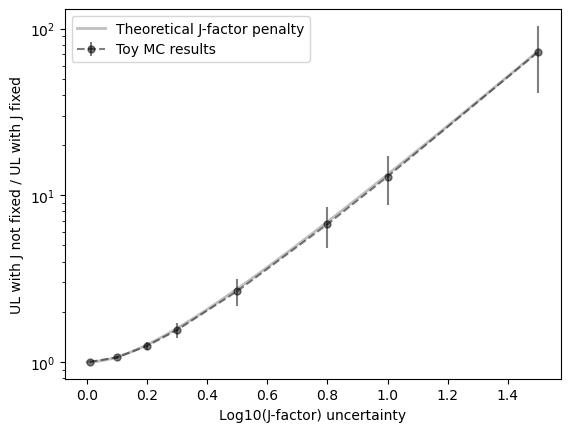

In [29]:
x = np.linspace(0.001,1.5, 100)
y = jfactor_penalty(lam=2.71, sigma=x, dist="lognormal", logbase='10')
plt.errorbar(sigmas, all_frac_means, yerr=all_frac_errs, marker='o', linestyle='--',
              markersize=5, alpha=0.5, label='Toy MC results', color='black')

plt.plot(x, y, color='grey', linewidth=2, alpha=0.5, label='Theoretical J-factor penalty')

plt.xlabel("Log10(J-factor) uncertainty")
plt.ylabel("UL with J not fixed / UL with J fixed")
plt.legend()

plt.yscale("log")

plt.savefig("Jfactor_penalty_toyMC_vs_theory.png", dpi=300)